# softmax回归
## 处理数据集

In [48]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

In [62]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
# 并除以255使得所有像素类型的数值均在0~1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans,download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans,download=True
)

In [65]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [73]:
mnist_train[5][1]

3

In [52]:
# 查看形状
#28x28像素，因为是灰度图像，通道数为1
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [74]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t_shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

In [75]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1):
    """绘制图像列表，可视化一下"""
    figsize = (num_cols * scale, num_rows*scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i , (ax, img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't_shirt'}>,
       <Axes: title={'center': 't_shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't_shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't_shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't_shirt'}>], dtype=object)

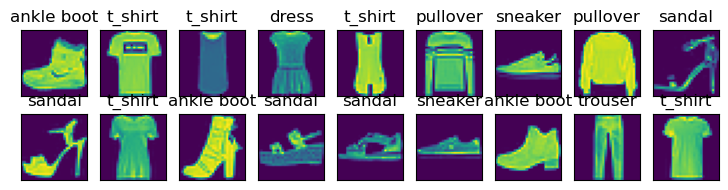

In [76]:
X,y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))

### 读取小批量

In [56]:
batch_size = 256
def get_dataloader_workers():
    """用4个进程读取数据"""
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

### 整合所有组件


In [57]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载数据集并加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize is not None:
        trans.insert(0,transforms.Resize((resize,resize)))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans,download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans,download=True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=False,
                           num_workers=get_dataloader_workers()))

In [58]:
# resize可以调整图片大小
train_iter, test_iter = load_data_fashion_mnist(32,resize=64)
for X,y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## 从0实现

In [59]:
from IPython import display

In [60]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 初始化模型参数
这里将28x28的样本图像铺平成784的向量，即将每个像素位置看成一个特征，忽略空间特征。
因为数据集有10个类别，所以输出有10个，所以权重就是784X10，偏置是1X10的行向量

In [61]:
num_inputs = 28 * 28
num_outputs = 10

W = torch.normal(0,0.01,size=(num_inputs, num_outputs),requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### softmax计算
1. 每个项求幂
2. 每一行求和，得到每个样本的规范化常数
3. 除一，确保总和为1

$$softmax(X)_{ij}=\frac{exp(X_{ij})}{\sum_kexp(X_{ik})}$$

In [23]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp / partition

In [77]:
# 测试
X =  torch.normal(0,1,(2,5))
X = softmax(X)
X,X.sum(1,keepdim=True)

(tensor([[0.0930, 0.3984, 0.2382, 0.0327, 0.2377],
         [0.2398, 0.2511, 0.0279, 0.2805, 0.2007]]),
 tensor([[1.],
         [1.]]))

### 定义模型和损失函数
1. 模型：softmax回归模型
2. 损失函数：交叉熵损失函数


In [25]:
def net(X):
    # reshape将图像展平为向量(256x784)
    y = X.reshape((-1,W.shape[0]))
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])), W) + b)

In [26]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y])

In [27]:
### 举个例子
# 2个样本的真实标签
y = torch.tensor([0,2])
# 2个样本对于三个类别的预测概率
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
# 选取第一个样本中第一个类的概率，以及第二个样本中第三个类的概率
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [28]:
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度
最后输出你总不能输出一个概率吧，要的还是给出具体是哪类。
当预测与标签分类一致，则正确，**分类精度就是正确预测数量与总预测数量之比**，这是非常重要的指标。
- y_hat若为矩阵，则第二个维度存的是每个类的预测分数，**使用argmax获取每行最大值的索引，那就是预测的类别**。
- 将预测类别与真实y元素进行比较，由于"=="对数据类型很敏感，所以将y_hat的数据类型转换成y的数据类型，然后比较，结果不是0就是1的张量，求和就会得到正确预测的数量。

In [29]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [30]:
accuracy(y_hat,y)/ len(y)

0.5

In [31]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [32]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) #正确预测数，预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [33]:
evaluate_accuracy(net, test_iter)

0.074

### 训练


In [34]:
def train_epoch_ch3(net, tran_iter, loss ,updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式(计算梯度)
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1]/metric[2]

In [35]:
import matplotlib.pyplot as plt
class Animator:
  """在动画中绘制数据"""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear',yscale='linear',
               fmts=('-','m--','g-','r:'),nrows=1,ncols=1,
               figsize=(3.5,2.5)):
    if legend is None:
      legend = []
    # d2l.use_svg_display()
    self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x,y):
    #向图表添加多个数据点
    if not hasattr(y,"__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x,"__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x,y,fmt in zip(self.X,self.Y,self.fmts):
      self.axes[0].plot(x,y,fmt)
    display.display(self.fig)
    display.clear_output(wait=True)
      

In [36]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel="epoch", xlim=[1,num_epochs],ylim=[0.3,0.9],
                       legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5 , train_loss
    assert train_acc <=1 and train_acc > 0.7 , train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [37]:
lr = 0.1
updater = torch.optim.SGD([W, b], lr=lr)

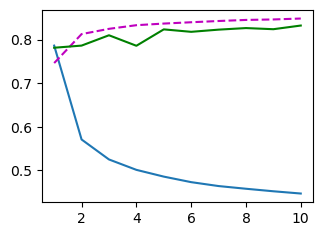

In [38]:
num_epochs = 10
train_ch3(net, train_iter, test_iter,cross_entropy, num_epochs,updater)

### 预测


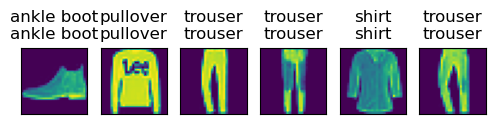

In [39]:
def predict_ch3(net, test_iter, n=6):
    for X,y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n]
    )
    
predict_ch3(net,test_iter)

## softmax的简洁实现

In [40]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.cuda.set_device(2)

In [41]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载数据集并加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize is not None:
        trans.insert(0,transforms.Resize((resize,resize)))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans,download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans,download=True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=False,
                           num_workers=get_dataloader_workers()))

In [42]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [43]:
### 定义展平层来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [44]:
loss = nn.CrossEntropyLoss(reduction='none')

In [45]:
trainer = torch.optim.SGD(net.parameters(),lr=0.1)

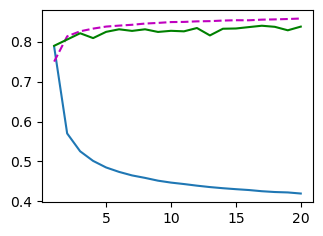

In [46]:
num_epochs = 20
train_ch3(net, train_iter, test_iter, loss,num_epochs, trainer)

In [47]:
print(torch.cuda.is_available())

True
